# Traffic Sign Classification

This notebook will classify traffic signs using deep learning models.

## About the Dataset
There are around 58 classes and each class has around 120 images. The labels.csv file has the respective description of the traffic sign class.

The 58 classes are:

|Class | Label |
| -----|------- |
|0  | Speed limit (5km/h) |
|1  | Speed limit (15km/h) |
|2  | Speed limit (30km/h) |
|3  | Speed limit (40km/h) |
|4  | Speed limit (50km/h) |
|5  | Speed limit (60km/h) |
|6  | Speed limit (70km/h) |
|7  | speed limit (80km/h) |
|8  | Dont Go straight or left |
|9  | Dont Go straight or Right |
|10 | Dont Go straight |
|11 | Dont Go Left |
|12 | Dont Go Left or Right |
|13 | Dont Go Right |
|14 | Dont overtake from Left |
|15 | No Uturn |
|16 | No Car |
|17 | No horn |
|18 | Speed limit (40km/h) |
|19 | Speed limit (50km/h) |
|20 | Go straight or right |
|21 | Go straight |
|22 | Go Left |
|23 | Go Left or right |
|24 | Go Right |
|25 | keep Left |
|26 | keep Right |
|27 | Roundabout mandatory |
|28 | watch out for cars |
|29 | Horn |
|30 | Bicycles crossing |
|31 | Uturn |
|32 | Road Divider |
|33 | Traffic signals |
|34 | Danger Ahead |
|35 | Zebra Crossing |
|36 | Bicycles crossing |
|37 | Children crossing |
|38 | Dangerous curve to the left |
|39 | Dangerous curve to the right |
|40 | Unknown1 |
|41 | Unknown2 |
|42 | Unknown3 |
|43 | Go right or straight |
|44 | Go left or straight |
|45 | Unknown4 |
|46 | ZigZag Curve |
|47 | Train Crossing |
|48 | Under Construction |
|49 | Unknown5 |
|50 | Fences |
|51 | Heavy Vehicle Accidents |
|52 | Unknown6 |
|53 | Give Way |
|54 | No stopping |
|55 | No entry |
|56 | Unknown7 |
|57 | Unknown8 |

## Main Objective

The main objective of this project is to identify the type of traffic sign from the image and classify the image within one of the above classes. The accuracy of the classification will be measured by the number of correct classifications out of the total amount of images in each class.

There are many companies involved in the self-driving car business. One of the key aspects for self driving cars is recognition of street signs. This analysis will evaluate a few different models on how well they are able to predict a street sign. The benefits from this analysis are being able to stop a car when a stop sign is identified, slow down or speed up when a speed limit sign is identified, and any other possible alerts a car would need based on the sign. It is important for the model to accurately identify the sign so that a car doesn't run through a stop sign, stop when it shouldn't, drive too fast or too slow.

In [1]:
import os
import pandas as pd 
import numpy as np
import sys
import glob
import tensorflow as tf 
import keras 
from tensorflow.keras import layers, models, backend
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from keras import optimizers
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from random import sample

## Data Exploration

The data provided in the dataset is plotted below as a histogram to show the distribution of the classes. There are a few classes that are under represented in the dataset.

Using Keras Data Generators the images are rotated, shifted, sheared, and zoomed to provide additional images to the dataset. This provides the models with additional data based on the existing data. This helps the model to be more robust. Each model is also preprocessed using the Keras preprocessing function specific to the model. This ensures that the images is in the format the model expects.

<Axes: xlabel='label', ylabel='count images'>

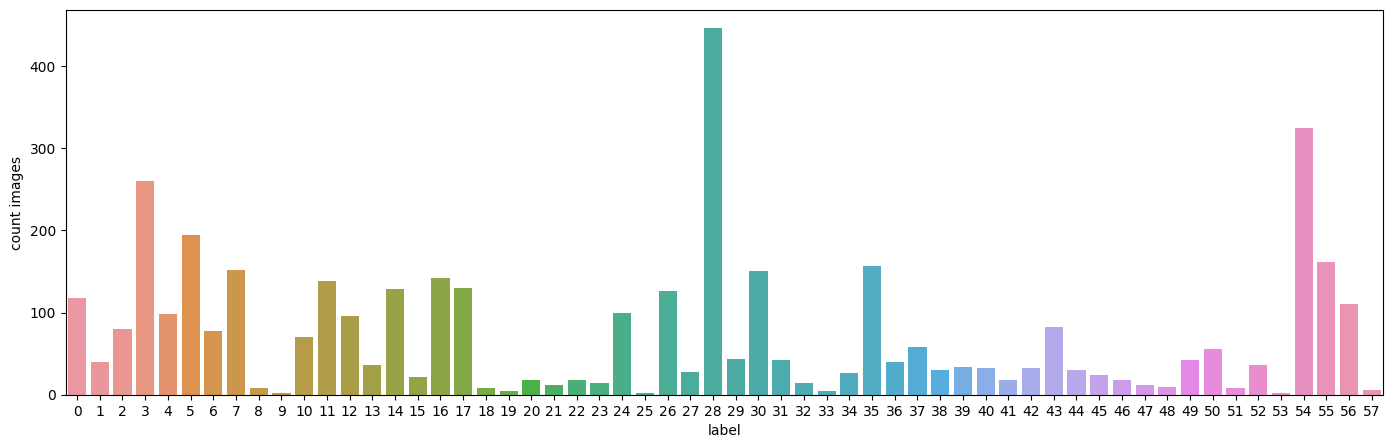

In [2]:
image_paths = list(Path('../input/traffic-sign-dataset-classification/traffic_Data/DATA').glob(r'**/*.png'))
labels = list(map(lambda path: os.path.split(os.path.split(path)[0])[1], image_paths))

images = pd.Series(image_paths).astype(str)
labels = pd.Series(labels).astype(str)
frame = {'image':images, 'label':labels}
image_df = pd.DataFrame(frame)

count_labels = image_df.groupby(['label']).size()
count_labels.index=count_labels.index.astype(int)
count_labels = count_labels.sort_index()
count_labels.index=count_labels.index.astype(str)
plt.figure(figsize=(17,5))
plt.ylabel('count images')
sns.barplot(x=count_labels.index, y=count_labels)


Random images from the dataset.

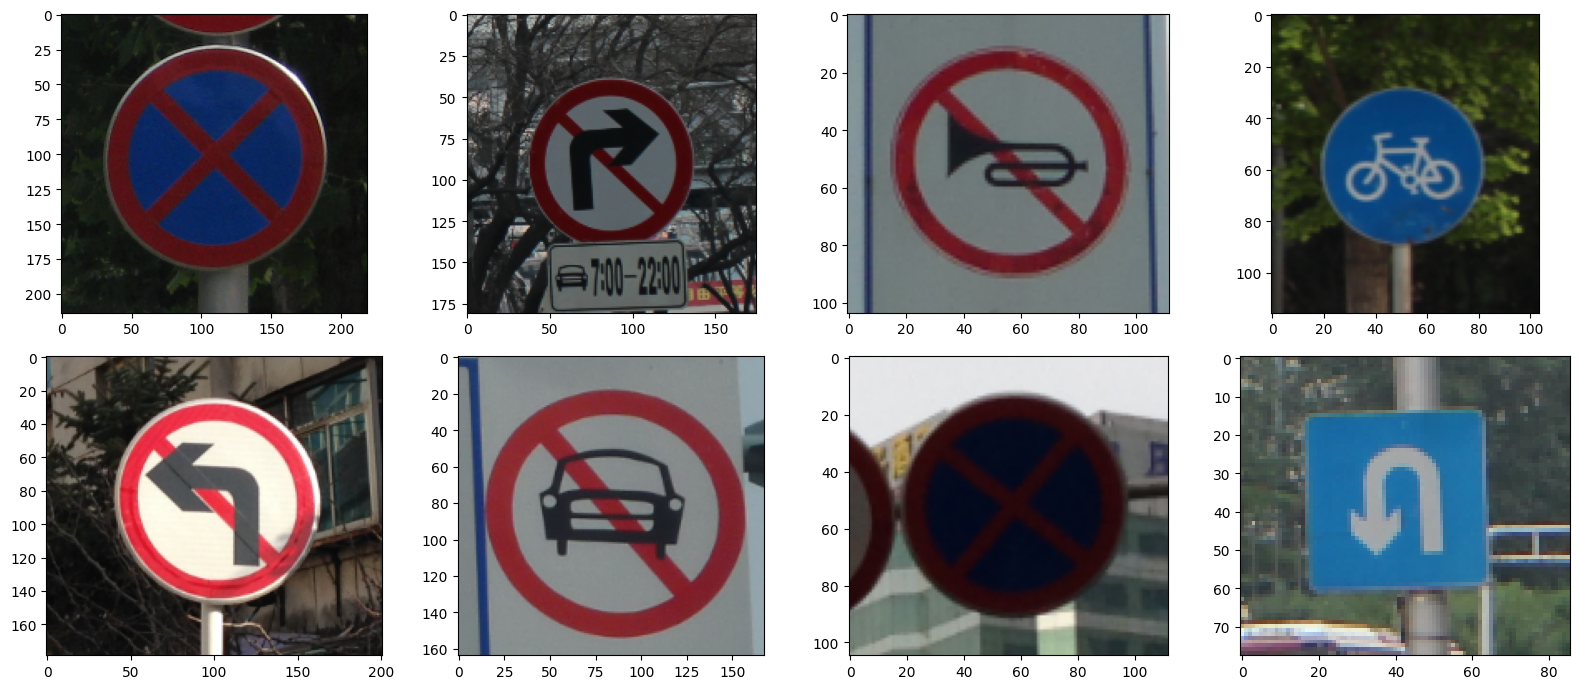

In [3]:
fig, axes = plt.subplots(2,4, figsize=(16, 7))
for img, ax in zip(sample(image_paths, len(axes.flat)), axes.flat):
    ax.imshow(plt.imread(img))
plt.tight_layout()
plt.show()

## Model specifications

Model specifications are defined for batch_size, image_size, minimum images per class, and the number of epochs.

In [4]:
batch_size = 64
img_height = 128
img_width = 128
SEED = 456
SPLIT_MINIMUM_COUNT = 10
EPOCH = 50

## Helper Functions

Functions to split the dataset with a minimum number of images per class are defined below.

In [5]:
def split_dataset(df, rate=SPLIT_MINIMUM_COUNT):
    count_labels = df.groupby(['label']).size()
    count_labels_df = count_labels.to_frame(name='count_images').reset_index()
    
    drop_label_list = list(
          count_labels_df['label'].\
          loc[count_labels_df['count_images']<SPLIT_MINIMUM_COUNT]
      )
    
    drop_df = df.copy()
    split_df = df.copy()
    
    for index, row in df.iterrows():
        if str(row.label) in drop_label_list:
          split_df = split_df.drop(index)
        else:
          drop_df = drop_df.drop(index)
    
    return split_df, drop_df

def custom_train_test_split(df):
    labels = df.label.unique()
    test_df = pd.DataFrame()
    
    for label in labels:
        label_samples = df.loc[df.label==label]
        test_df = pd.concat([test_df, label_samples.sample(len(label_samples)//10+1,
                               random_state=SEED)])
        
        train_df = df.drop(list(test_df.index), axis=0)
        test_df = test_df.sample(frac=1, random_state=SEED)
        train_df = train_df.sample(frac=1, random_state=SEED)
    
    return train_df, test_df

In [6]:
split_df, _ = split_dataset(image_df)
train_df, test_df = custom_train_test_split(split_df)
train, val = custom_train_test_split(train_df)
train_labels = train_df.groupby(['label']).size()
NUM_CLASSES = len(train_labels)

## Data Generators

A function to geenrate Data Generators based on the model are defined below. The data generators are the same except for the specific preprocessing baed on the model.

Train, Validation, and Test datasets are then generated.

In [7]:
def get_generators(preprocessing_function):
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
    rotation_range = 10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='constant',
    shear_range=0.1,
    zoom_range=0.2,
    )
    
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocessing_function,
    )

    return train_generator, test_generator

train_generator, test_generator = get_generators(tf.keras.applications.vgg16.preprocess_input)

train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=SEED,
                                                )

val_images = test_generator.flow_from_dataframe(dataframe=val,
                                                x_col='image',
                                                y_col='label',
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=SEED,
                                            )

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                )


Found 3683 validated image filenames belonging to 49 classes.
Found 396 validated image filenames belonging to 49 classes.
Found 443 validated image filenames belonging to 49 classes.


## Model functions

A function that creates the model using transfer learning is defined. A function that reports the accuracy of the model to test data and a function that generates a confusion matrix are defined.

In [8]:
def create_model(basemodel, NUM_CLASSES):
    basemodel.trainable = False

    inputs = Input(shape=(img_height, img_width, 3))
    x = basemodel(inputs)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs, outputs) 
    
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def get_accuracy_metric(model, test_images, true_labels, class_names):
    pred_probs = model.predict(test_images)  # Get probability outputs
    pred_labels = np.argmax(pred_probs, axis=1)  # Convert to class indices

    correct_predictions = np.sum(pred_labels == true_labels)
    accuracy = correct_predictions / len(true_labels)
    
    # Print the accuracy
    print(f"Accuracy: {accuracy:.4f}")
    
    clr = classification_report(true_labels, pred_labels, target_names=class_names, zero_division=0.0)
    print("Classification Report:\n----------------------\n", clr)

    return pred_labels

def display_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)  
    fig_width = len(class_names) * 0.5
    fig_height = len(class_names) * 0.5
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(len(class_names))+.5, class_names, rotation= 90)
    plt.yticks(np.arange(len(class_names))+.5, class_names, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

callback = EarlyStopping(monitor='val_loss',
                         patience=10,
                         min_delta=0.01,
                         start_from_epoch=10,
                         restore_best_weights=True
                         )

## Deep Learning Models

The traffic signs will be classified with the following models as the base model:

1. VGG16
2. ResNet152
3. ConvNeXtXLarge
4. EfficientNetV2B0

Using Transfer learning each basemodel adds a classification head to classify the traffic sign classes. Each model will be evaluated by its accuracy to determine the best model.

A function to get the test data true labels and class names is defined below.

In [9]:
def get_test_data(test_images):
    true_labels = []
    for _, labels in test_images:
        true_labels.extend(np.argmax(labels, axis=1))
        if len(true_labels) >= test_images.samples:
            break  # Stop when all samples are processed
    
    true_labels = np.array(true_labels)
    class_names = list(test_images.class_indices.keys())

    return true_labels, class_names

### VGG16

VGG16 is a convolutional neural network (CNN) architecture. It is known for its use in image recognition and classification, particularly for tasks like object detection and image classification. 

In [10]:
from keras.applications import vgg16, ResNet152, ConvNeXtXLarge, EfficientNetV2B0

vgg16_model = create_model(vgg16.VGG16(include_top=False,
                                       weights='imagenet',
                                       input_shape=(img_height, img_width, 3),
                                       pooling="avg",
                                      ),
                           NUM_CLASSES
                          )
vgg16_history = vgg16_model.fit(train_images,
                           epochs=EPOCH,
                           validation_data=val_images,
                           callbacks=[callback])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 60s 696ms/step - accuracy: 0.3959 - loss: 3.5303 - val_accuracy: 0.7980 - val_loss: 0.6919
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - accuracy: 0.8205 - loss: 0.5937 - val_accuracy: 0.8586 - val_loss: 0.4014
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.8722 - loss: 0.3932 - val_accuracy: 0.9015 - val_loss: 0.2818
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.8985 - loss: 0.3378 - val_accuracy: 0.9141 - val_loss: 0.2684
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.9168 - loss: 0.2517 - val_accuracy: 0.9369 - val_loss: 0.1722
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.9263 - loss: 0.2340 - val_accuracy: 0.9419 - val_loss: 0.1551
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - accuracy: 0.9376 - loss: 0.1903 - val_accuracy: 0.9571 - val_loss: 0.1379
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - accuracy: 0.9524 - loss: 0.1486 - val_accuracy: 0.947

In [11]:
true_labels, class_names = get_test_data(test_images)

In [12]:
pred_labels = get_accuracy_metric(vgg16_model, test_images, true_labels, class_names)

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
Accuracy: 0.9503
Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00         4
          14       1.00      0.85      0.92        13
          15       1.00      1.00      1.00         3
          16       1.00      0.93      0.97        15
          17       0.88      1.00      0.93        14
           2       0.75      1.00      0.86         9
          20       1.00      1.00      1.00         2
          21       1.00      1.00      1.00         2
          22       1.00      1.00      1.00         2
          23       1.00      1.00      1.00         2
          24       1.00      1.00 

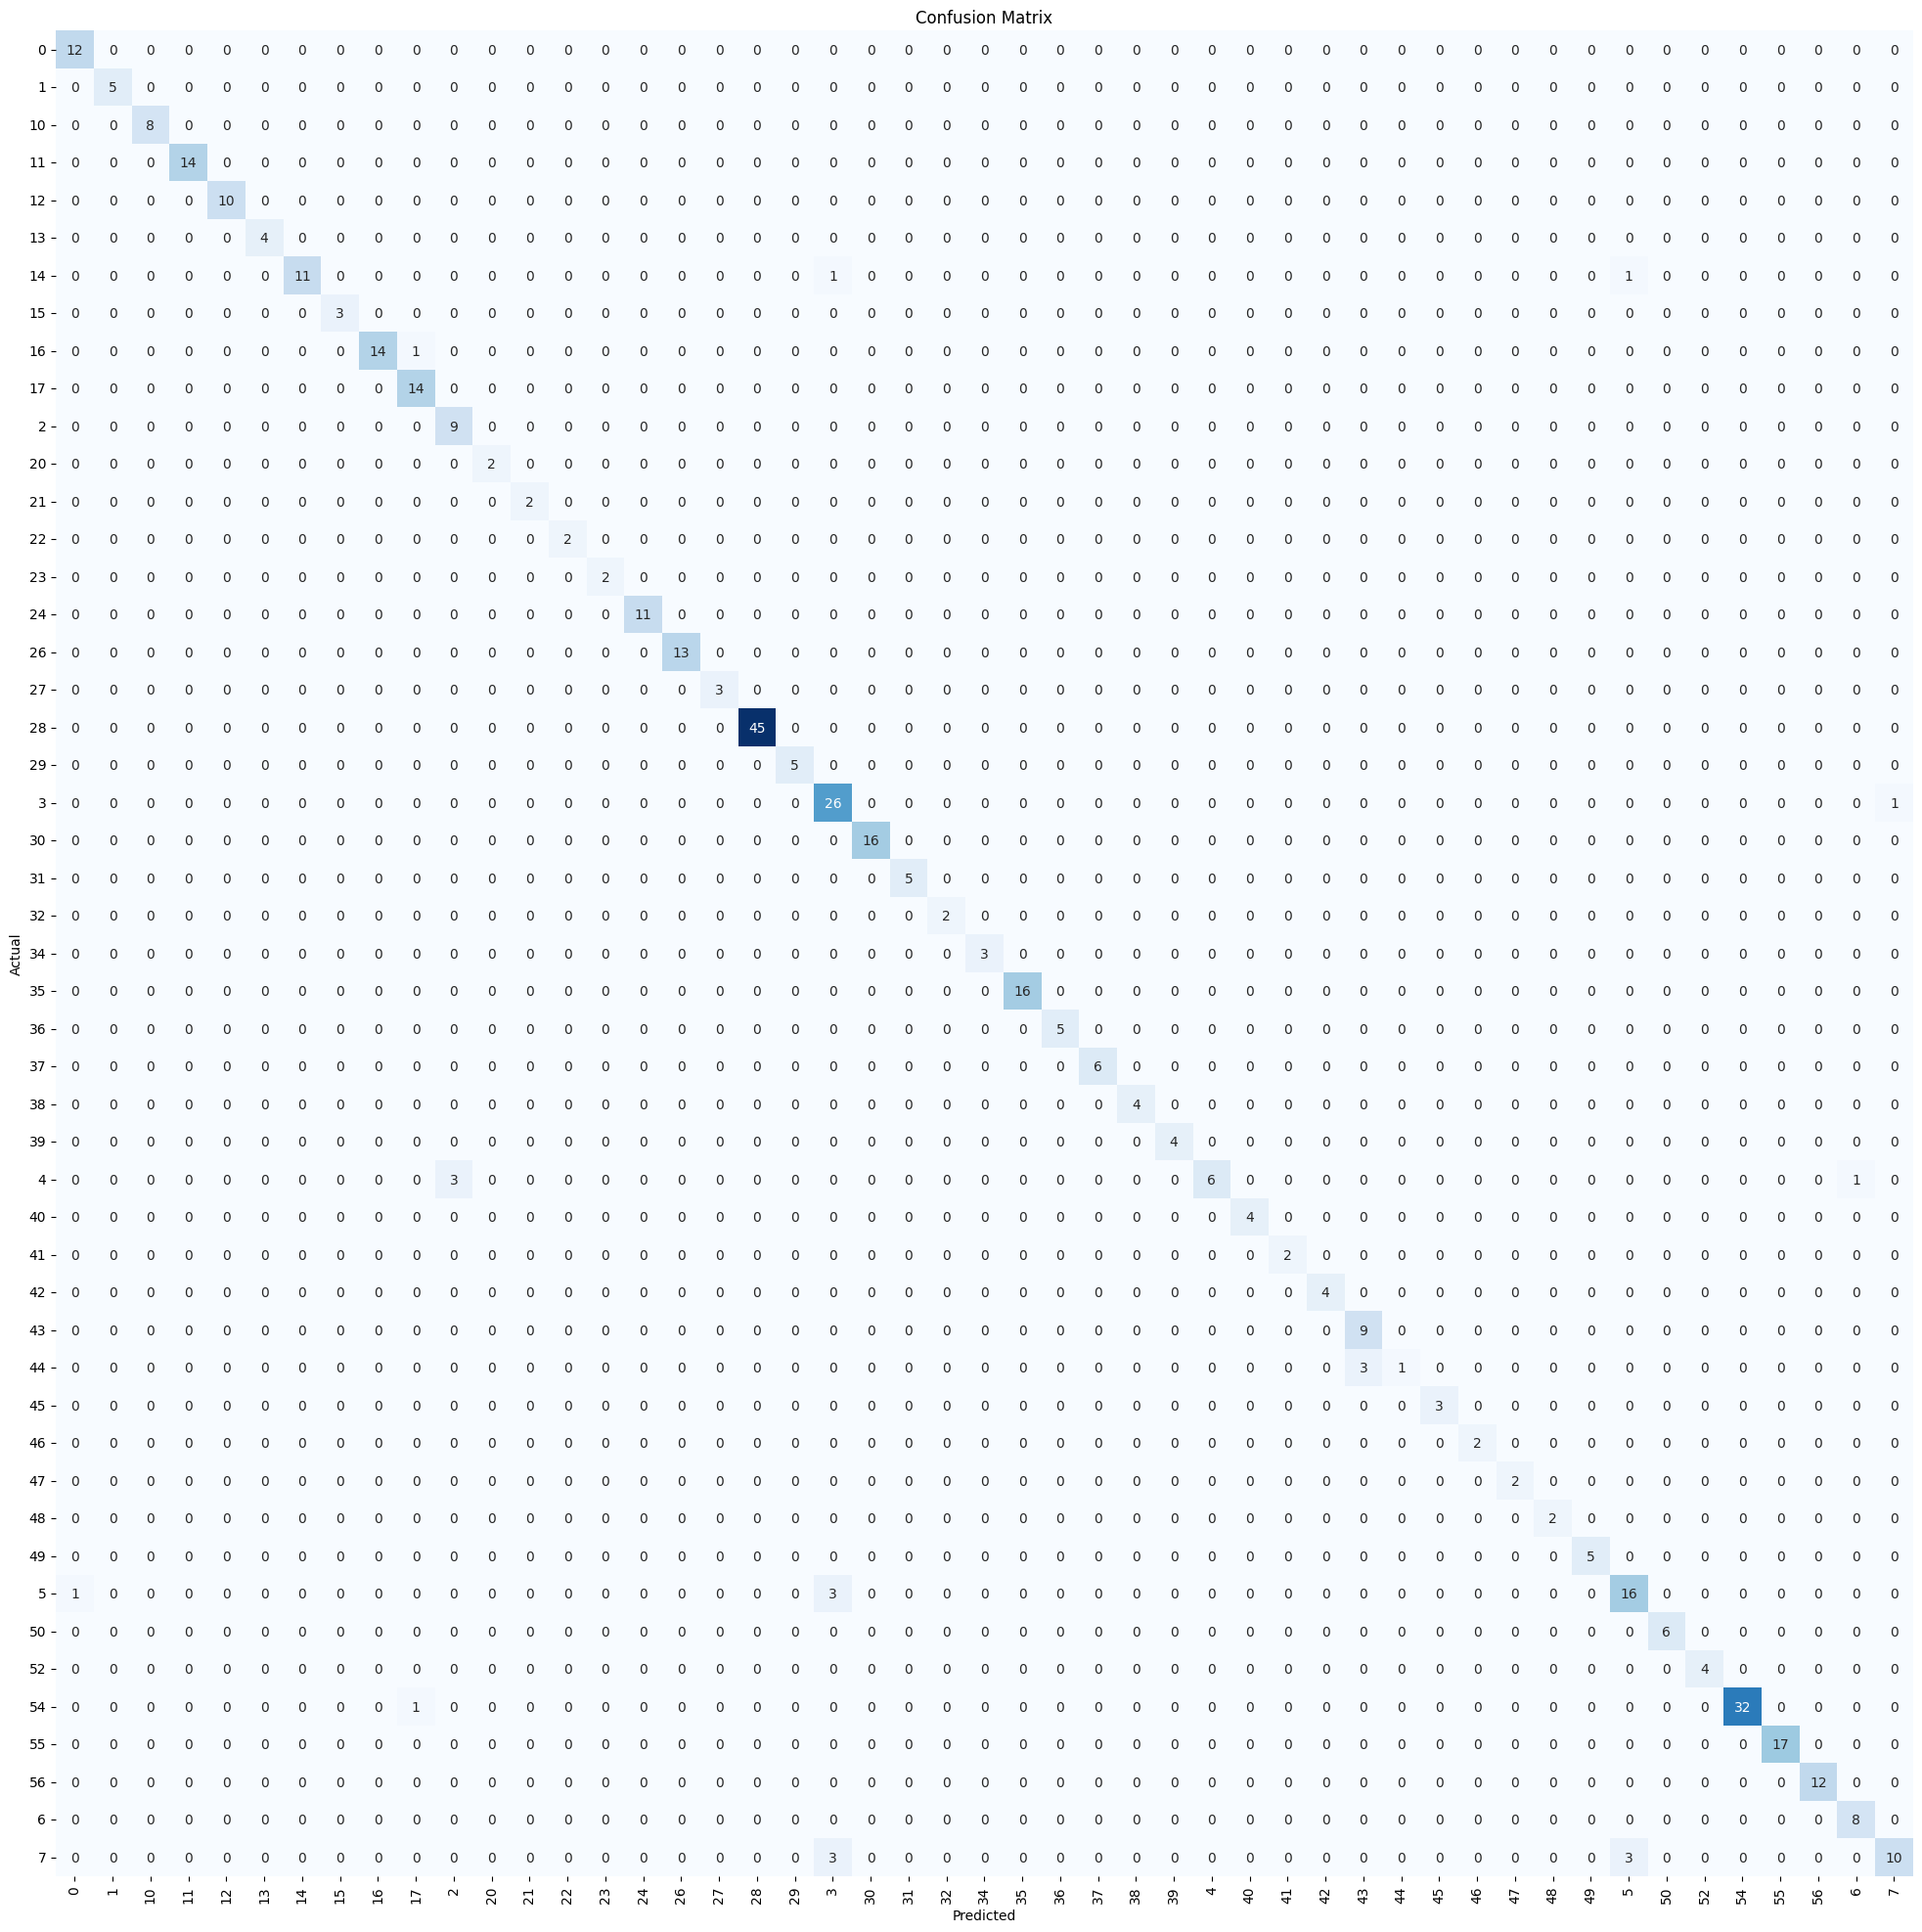

In [13]:
display_confusion_matrix(true_labels, pred_labels, class_names)

### ResNet152

Residual Learning:
ResNet-152, like other ResNets, utilizes the concept of residual learning, which allows for the training of much deeper networks by incorporating skip connections (also known as shortcut connections).

In [14]:
train_generator, test_generator = get_generators(tf.keras.applications.resnet.preprocess_input)

train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=SEED,
                                                )

val_images = test_generator.flow_from_dataframe(dataframe=val,
                                                x_col='image',
                                                y_col='label',
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=SEED,
                                            )

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                )


Found 3683 validated image filenames belonging to 49 classes.
Found 396 validated image filenames belonging to 49 classes.
Found 443 validated image filenames belonging to 49 classes.


In [15]:
resnet_model = create_model(ResNet152(include_top=False,
                                      weights='imagenet',
                                      input_shape=(img_height, img_width, 3),
                                      pooling="avg",
                                     ),
                            NUM_CLASSES
                           )
resnet_history = resnet_model.fit(train_images,
                           epochs=EPOCH,
                           validation_data=val_images,
                           callbacks=[callback])

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 63s 651ms/step - accuracy: 0.5150 - loss: 2.0864 - val_accuracy: 0.8359 - val_loss: 0.5052
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 335ms/step - accuracy: 0.8609 - loss: 0.4426 - val_accuracy: 0.8813 - val_loss: 0.3475
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.9004 - loss: 0.3317 - val_accuracy: 0.9066 - val_loss: 0.2940
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - accuracy: 0.9400 - loss: 0.1906 - val_accuracy: 0.9318 - val_loss: 0.2255
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.9493 - loss: 0.1560 - val_accuracy: 0.9217 - val_loss: 0.2159
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - accuracy: 0.9369 - loss: 0.1811 - val_accuracy: 0.9141 - val_loss: 0.2298
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 335ms/step - accuracy: 0.9524 - loss: 0.1486 - val_accuracy: 0.9369 - val_loss: 0.1669
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.9630 - loss: 0.1151 - val_accuracy: 0.941

In [16]:
true_labels, class_names = get_test_data(test_images)

In [17]:
pred_labels = get_accuracy_metric(resnet_model, test_images, true_labels, class_names)

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Accuracy: 0.9436
Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00         3
          16       1.00      0.73      0.85        15
          17       1.00      1.00      1.00        14
           2       0.75      1.00      0.86         9
          20       1.00      1.00      1.00         2
          21       1.00      1.00      1.00         2
          22       1.00      1.00      1.00         2
          23       1.00      1.00      1.00         2
          24       0.73      1.00 

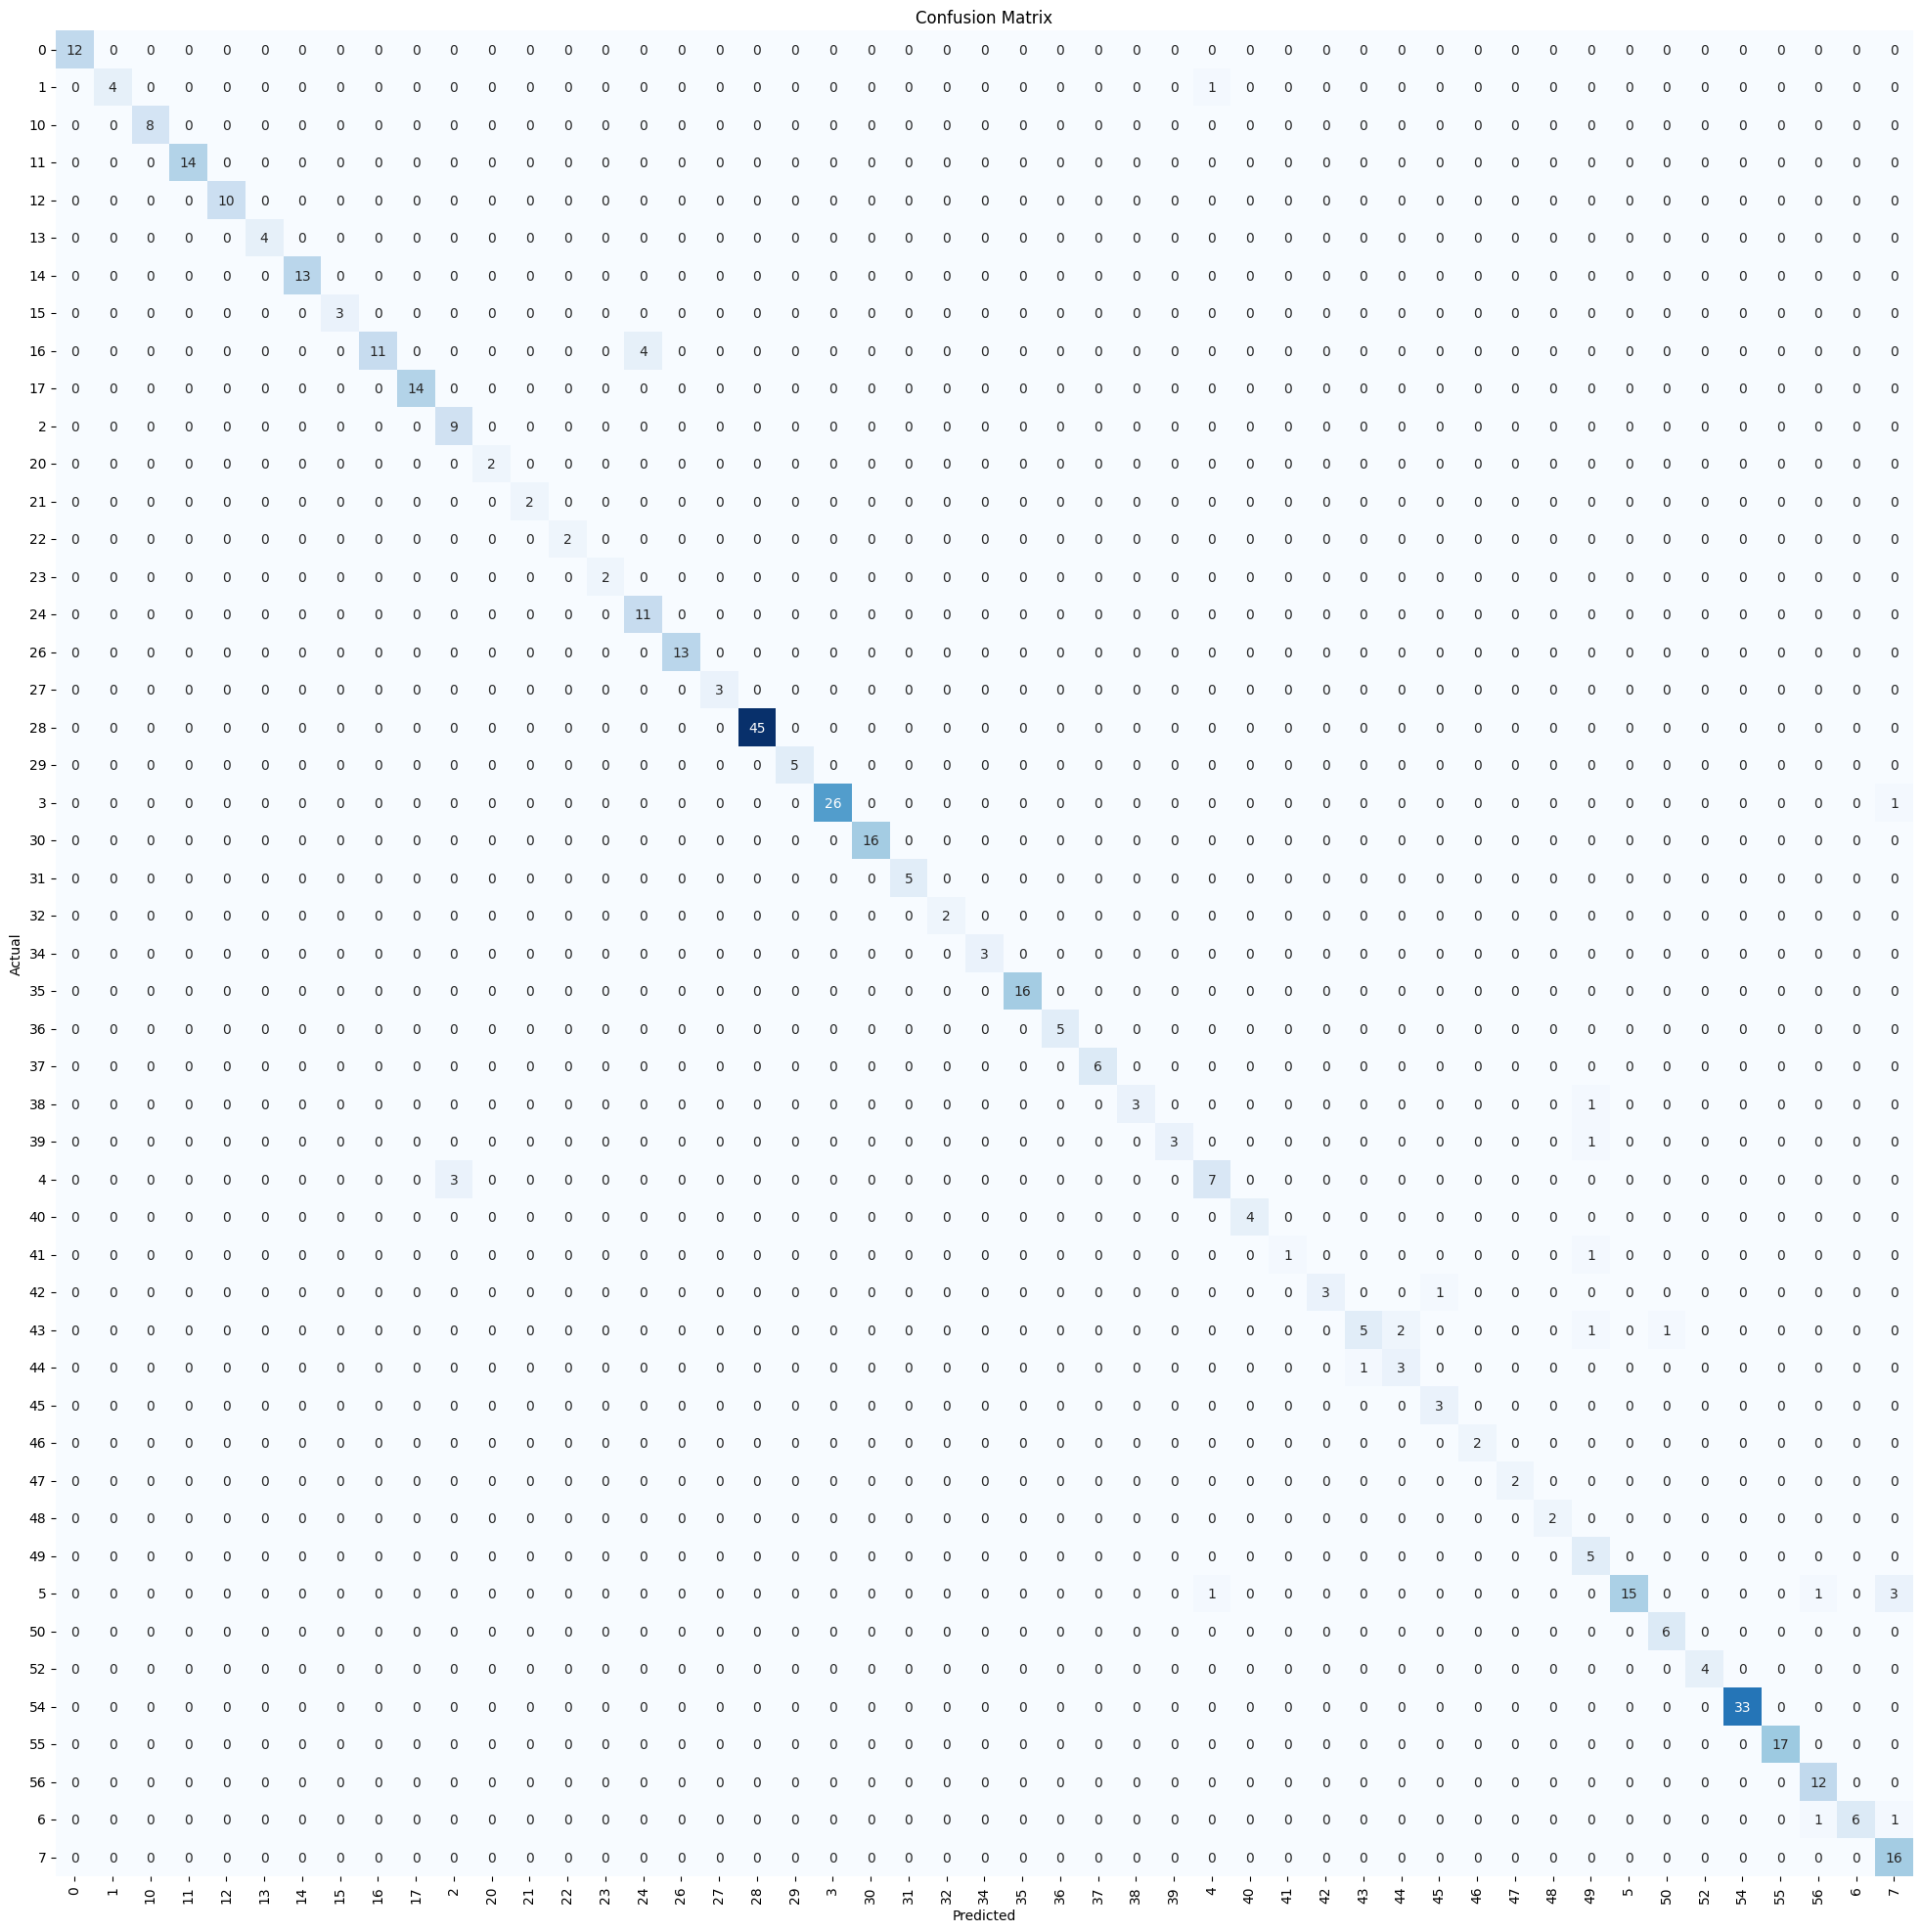

In [18]:
display_confusion_matrix(true_labels, pred_labels, class_names)

### ConvNeXtXLarge

A "convnet" refers to a Convolutional Neural Network (CNN), a specialized type of artificial neural network primarily used for tasks involving image and video analysis, object detection, and other computer vision applications

In [19]:
train_generator, test_generator = get_generators(tf.keras.applications.convnext.preprocess_input)

train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=SEED,
                                                )

val_images = test_generator.flow_from_dataframe(dataframe=val,
                                                x_col='image',
                                                y_col='label',
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=SEED,
                                            )

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                )

Found 3683 validated image filenames belonging to 49 classes.
Found 396 validated image filenames belonging to 49 classes.
Found 443 validated image filenames belonging to 49 classes.


In [20]:
convnet_model = create_model(ConvNeXtXLarge(include_top=False,
                                            weights='imagenet',
                                            input_shape=(img_height, img_width, 3),
                                            pooling="avg",
                                           ),
                             NUM_CLASSES
                            )
convnet_history = convnet_model.fit(train_images,
                           epochs=EPOCH,
                           validation_data=val_images,
                           callbacks=[callback])

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.4997 - loss: 2.0328 - val_accuracy: 0.8056 - val_loss: 0.6581
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8771 - loss: 0.4122 - val_accuracy: 0.9116 - val_loss: 0.3298
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9289 - loss: 0.2310 - val_accuracy: 0.9394 - val_loss: 0.2236
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9528 - loss: 0.1536 - val_accuracy: 0.9444 - val_loss: 0.1854
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9597 - loss: 0.1291 - val_accuracy: 0.9495 - val_loss: 0.1659
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9805 - loss: 0.0819 - val_accuracy: 0.9495 - val_loss: 0.1689
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9714 - loss: 0.0955 - val_accuracy: 0.9722 - val_loss: 0.1132
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9800 - loss: 0.0812 - val_accuracy: 0.9697 - val_loss: 0.0950
Ep

In [21]:
true_labels, class_names = get_test_data(test_images)

In [22]:
pred_labels = get_accuracy_metric(convnet_model, test_images, true_labels, class_names)

7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
Accuracy: 0.9819
Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5
          10       1.00      0.88      0.93         8
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00        13
          15       0.75      1.00      0.86         3
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        14
           2       0.82      1.00      0.90         9
          20       1.00      1.00      1.00         2
          21       1.00      1.00      1.00         2
          22       1.00      1.00      1.00         2
          23       1.00      1.00      1.00         2
          24       1.00      1.00 

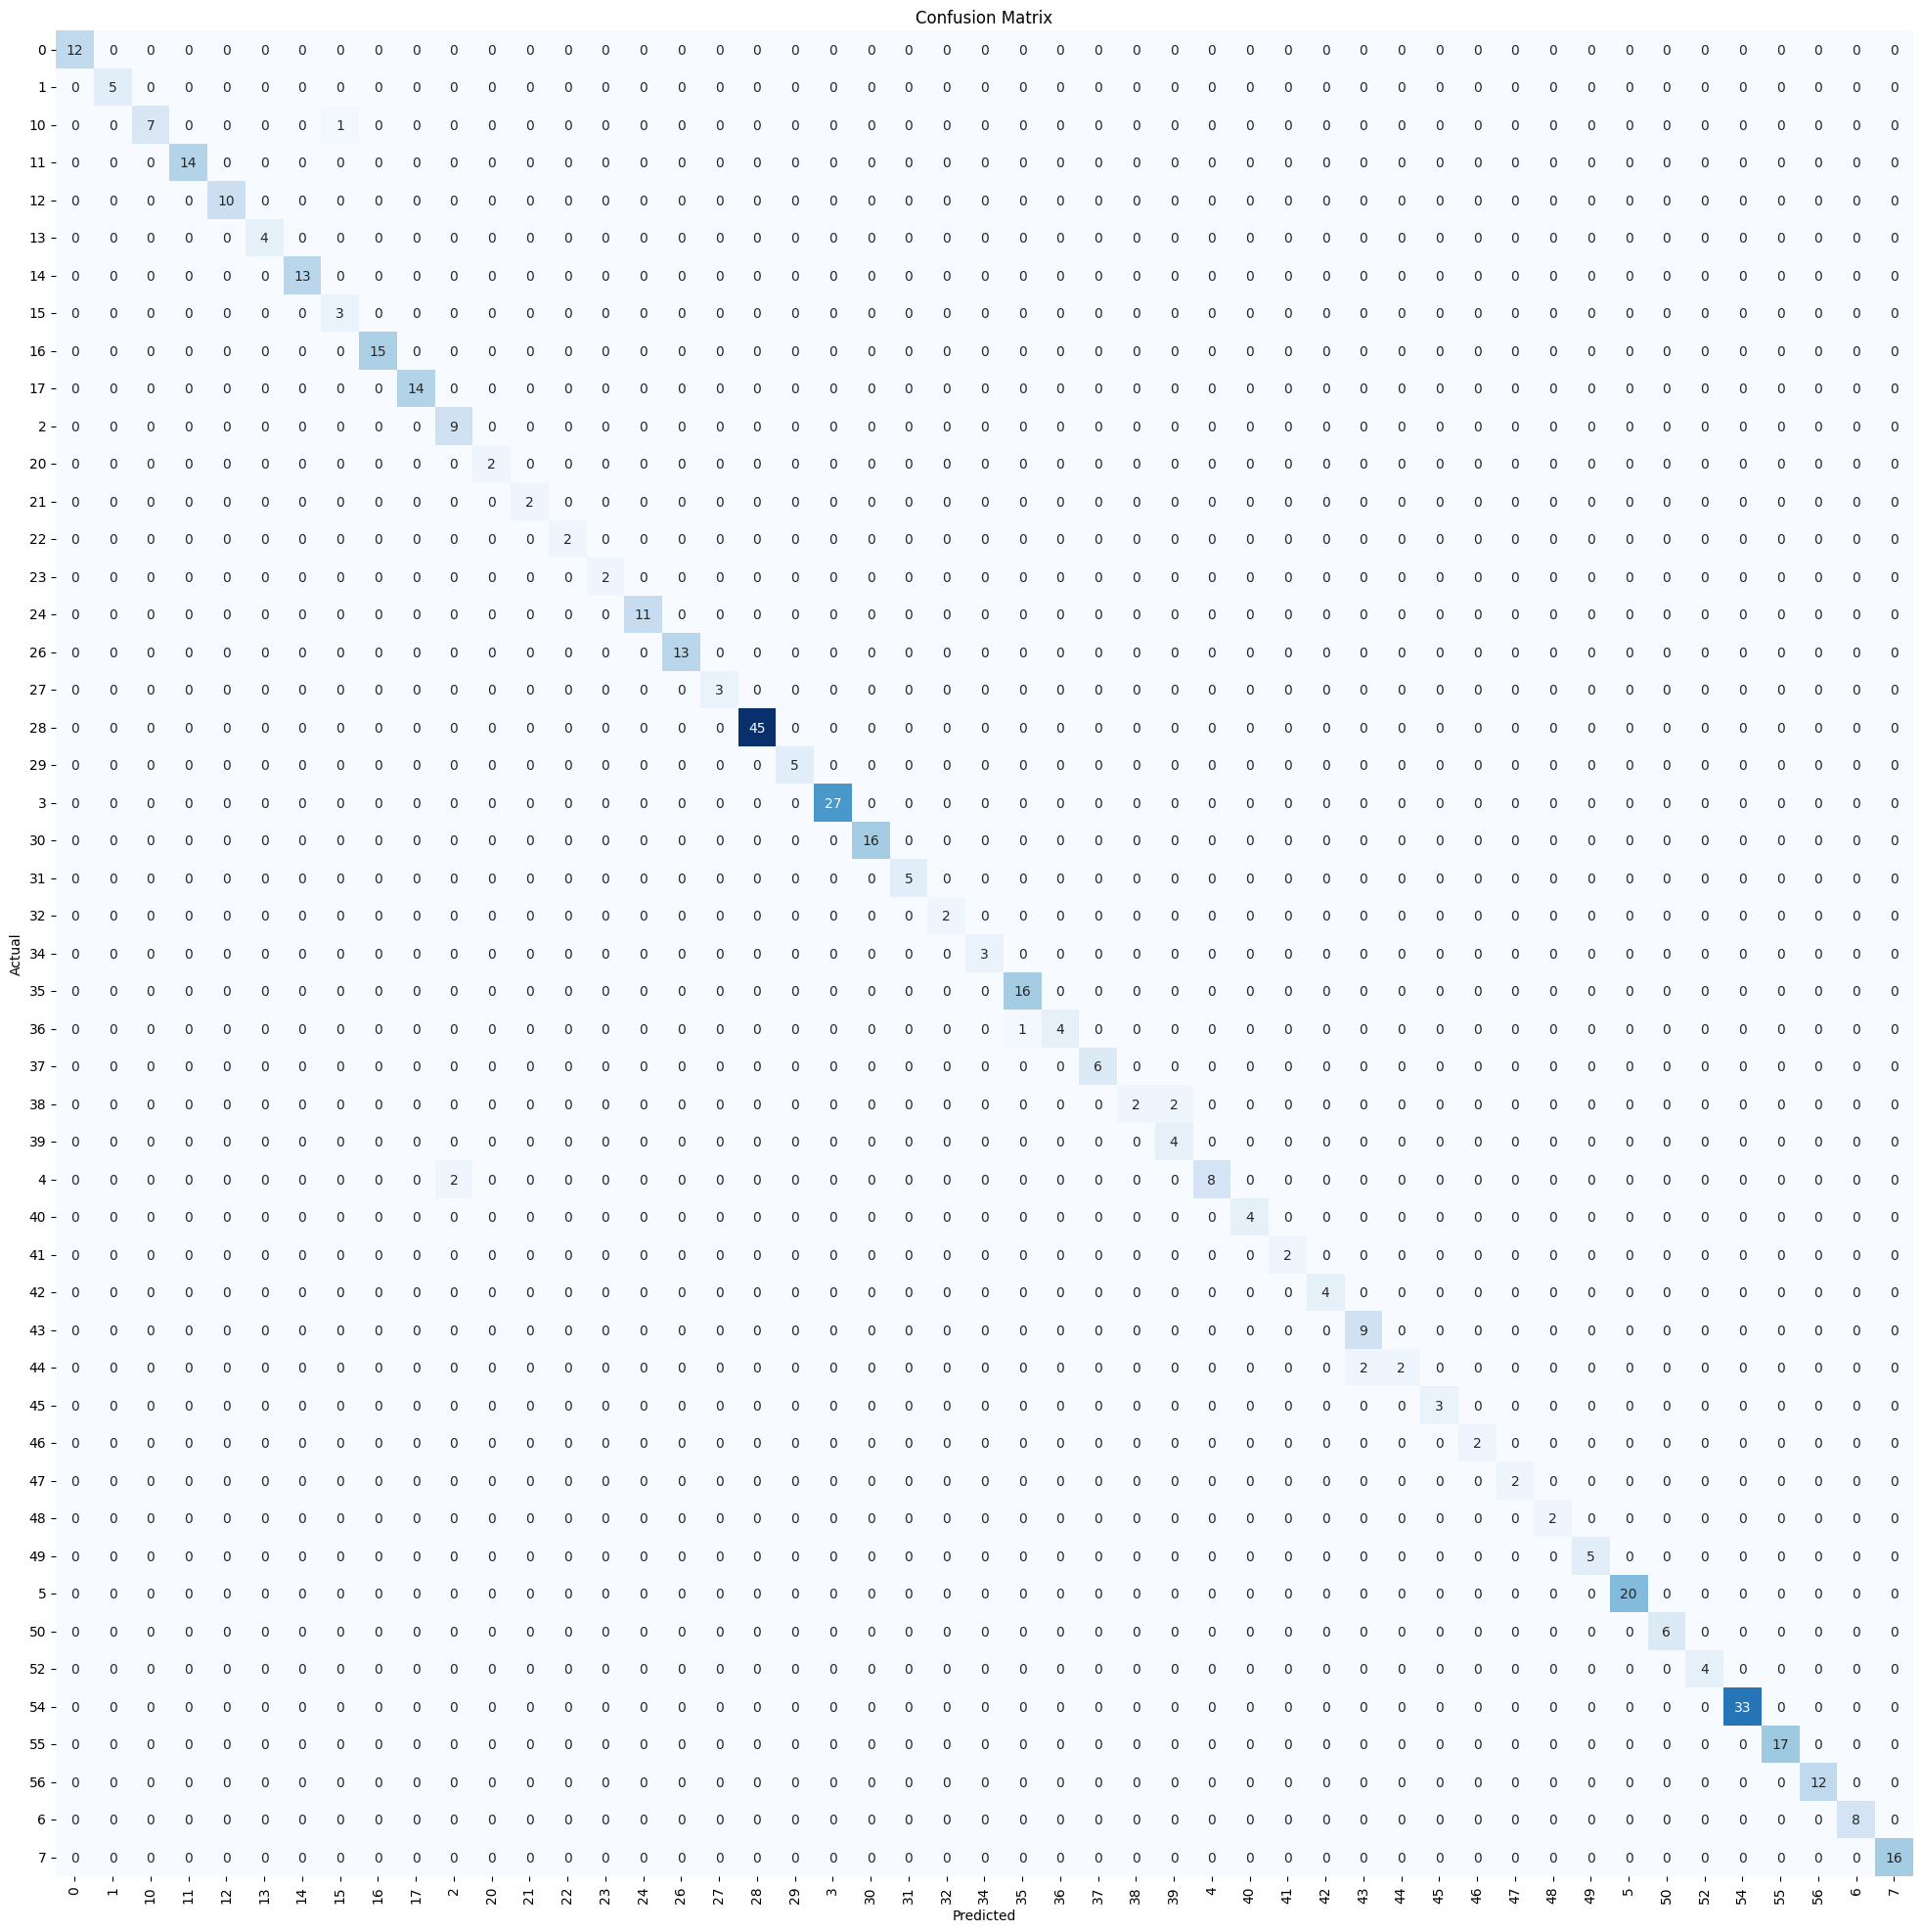

In [23]:
display_confusion_matrix(true_labels, pred_labels, class_names)

### EfficientNetV2B0

EfficientNet is a family of convolutional neural network (CNN) architectures for computer vision, known for their efficiency and high accuracy, achieved through a method called compound scaling that uniformly scales depth, width, and resolution.

In [24]:
train_generator, test_generator = get_generators(tf.keras.applications.efficientnet.preprocess_input)

train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=SEED,
                                                )

val_images = test_generator.flow_from_dataframe(dataframe=val,
                                                x_col='image',
                                                y_col='label',
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=SEED,
                                            )

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                )

Found 3683 validated image filenames belonging to 49 classes.
Found 396 validated image filenames belonging to 49 classes.
Found 443 validated image filenames belonging to 49 classes.


In [25]:
efficient_model = create_model(EfficientNetV2B0(include_top=False,
                                                weights='imagenet',
                                                input_shape=(img_height, img_width, 3),
                                                pooling="avg",
                                               ),
                               NUM_CLASSES
                              )
efficient_history = efficient_model.fit(train_images,
                           epochs=EPOCH,
                           validation_data=val_images,
                           callbacks=[callback])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 63s 663ms/step - accuracy: 0.4708 - loss: 2.1551 - val_accuracy: 0.8535 - val_loss: 0.7033
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.8750 - loss: 0.4470 - val_accuracy: 0.8889 - val_loss: 0.4371
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.9175 - loss: 0.2906 - val_accuracy: 0.9192 - val_loss: 0.2895
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 302ms/step - accuracy: 0.9501 - loss: 0.1838 - val_accuracy: 0.9520 - val_loss: 0.2154
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.9564 - loss: 0.1576 - val_accuracy: 0.9343 - val_loss: 0.2042
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.9511 - loss: 0.1643 - val_accuracy: 0.9520 - val_loss: 0.2010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.9583 - loss: 0.1256 - val_accuracy: 0.9495 - val_loss: 0.1818
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - accuracy: 0.9697 - loss: 0.0985 - val_accuracy: 0.972

In [26]:
true_labels, class_names = get_test_data(test_images)

In [27]:
pred_labels = get_accuracy_metric(efficient_model, test_images, true_labels, class_names)

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Accuracy: 0.9549
Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        14
          12       0.91      1.00      0.95        10
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00         3
          16       1.00      0.80      0.89        15
          17       0.88      1.00      0.93        14
           2       0.75      1.00      0.86         9
          20       1.00      1.00      1.00         2
          21       1.00      1.00      1.00         2
          22       1.00      1.00      1.00         2
          23       1.00      1.00      1.00         2
          24       1.00      1.00 

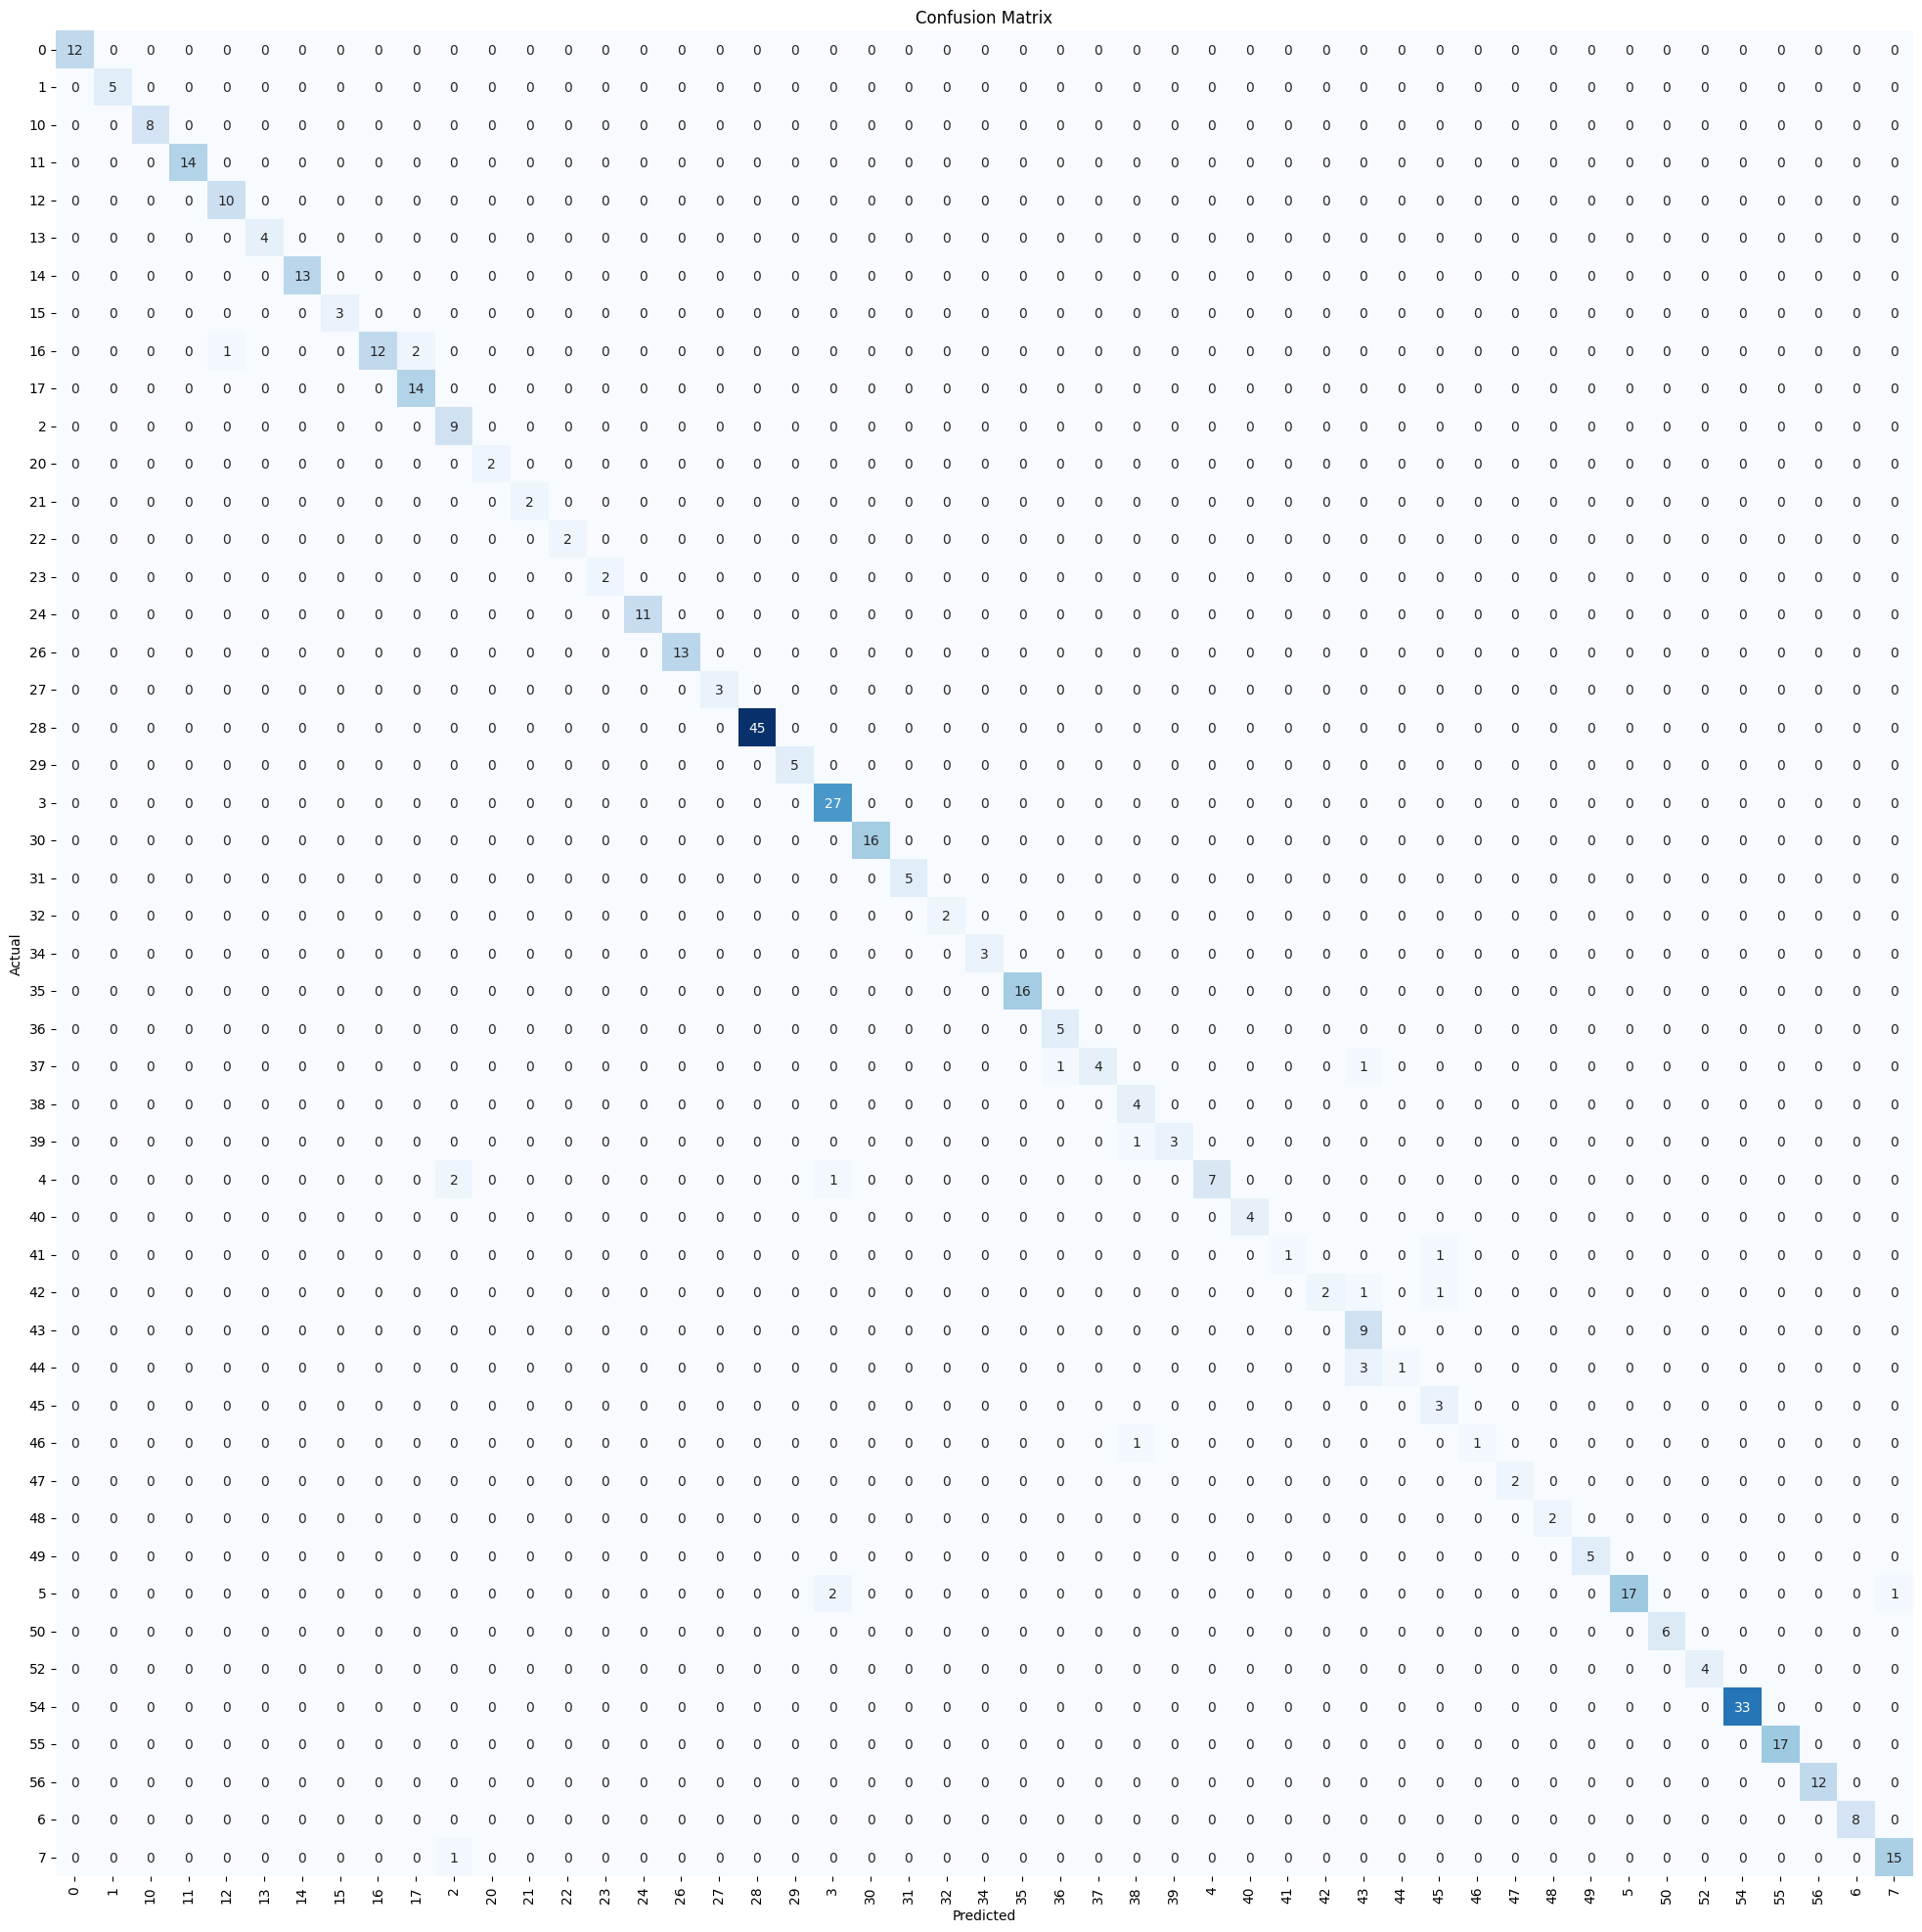

In [28]:
display_confusion_matrix(true_labels, pred_labels, class_names)

## Summary

### Suggested Model

All of the models performed well with the following accuracies.

|Model | Test Accuracy |
| -----|------- |
| VGG16 | 96.16% |
| ResNet152 | 97.97% |
| ConvNet | 97.52% |
| EfficientNet | 94.81% |

Based on these accuracies ResNet and ConvNet would be the suggested models.

### Key Findings

Some of the models were prone to overfitting as they performed well on the test and even validation data but not as well on the test data. Transfer learning was very effictive on increasing the speed to train the models on the new data while still providing high accuracy.

### Next Steps

For this evaluation the models were tested using a Random Seed for repeatability. Running a Monte Carlo simulation with a seed would allow for a better evaluation on the model performace.

The dataset was not very large or encompassing all of the possible traffic signs. Adding additional images would improve the testing. Additionaly, augementing the data with more variations of the images would help train the models.

There are many more models that could be evaluated for this application as well. In the future more models should be used to find the highest accuracy.